# <center>Theme: "Prediction of combined-cycle power plant energy production using AutoML tools" <center>
<center> Master´s student: Gabriel Alejandro Aguilar Farrera <center>
<center> Course: AutoML <center>
<center> Institution: Centro de Investigación en Matemáticas A.C. <center>

# <center>Abstractc:<center>
In this notebook we propose to do: **Linear regression model**, **Ridge regression model**, **Lasso regression model** and the framework **AutoKeras** with the data base 'Combyned Cycle Power Plant Data Set' to predict que values of EP.
    
URL: https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant
    
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.
We provide the data both in .ods and in .xlsx formats.
    
Variables:
* T: Temperature
* AP: Ambient Pressure
* RH: Relative Humidity
* V: Exhaust Vacuum
* EP: net hourly electrical energy output (Dependent variable)
    
Additional Variables Information:
    
Features consist of hourly average ambient variables 
* Temperature (T) in the range 1.81°C and 37.11°C,
* Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
* Relative Humidity (RH) in the range 25.56% to 100.16%
* Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
* Net hourly electrical energy output (EP) 420.26-495.76 MW
    
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

# 1. Import libraries and add Path 

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os                           

# Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet          # Ridge and Lasso Regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# AutoKeras library
import autokeras as ak
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

# Metrics
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

# Linear Regression libraries
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model

# CV libraries
from sklearn.experimental import enable_halving_search_cv  # Habilitar HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Time library
import time

# Visualitation libraries
%config InlineBackend.figure_format = 'retina'   # Improve image quality

# Ignora todos los warnings
import warnings
warnings.filterwarnings("ignore")

#Scorer Grid, Halving y Random
from sklearn.metrics import make_scorer
scorer = make_scorer(r2_score)

# Show the graphs
%matplotlib inline

Using TensorFlow backend


In [2]:
pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: d:\gabri\documents\anaconda\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: category-encoders, dtreeviz, factor-analyzer, imbalanced-learn, ISLP, librosa, mapclassify, mglearn, pca, pingouin, pmdarima, pycaret, pyLDAvis, pyod, scikit-learn-intelex, scikit-plot, sklearn-deap, sktime, tbats, TractSeg, tslearn, yellowbrick
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Establecer la variable de entorno HOME
os.environ['HOME'] = 'D:\\gabri'

# Ruta que deseas agregar al PATH
nueva_ruta = r'C:\Users\gabri\Downloads\Graphviz\bin'

# Obtén el valor actual del PATH
path_actual = os.environ["PATH"]

# Agrega la nueva ruta al PATH si no está ya presente
if nueva_ruta not in path_actual:
    os.environ["PATH"] = nueva_ruta + os.pathsep + path_actual

print("Ruta agregada al PATH:", nueva_ruta)

Ruta agregada al PATH: C:\Users\gabri\Downloads\Graphviz\bin


# 2. Import dataset

In [4]:
path = 'Folds5x2_pp.xlsx'
data = pd.read_excel(path)
print('Number of instances:', data.shape[0])
print('Number of variables:', data.shape[1])
print(data.head(10))

Number of instances: 9568
Number of variables: 5
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90
5  26.27  59.44  1012.23  58.77  443.67
6  15.89  43.96  1014.02  75.24  467.35
7   9.48  44.71  1019.12  66.43  478.42
8  14.64  45.00  1021.78  41.25  475.98
9  11.74  43.56  1015.14  70.72  477.50


# 3.Data exploration

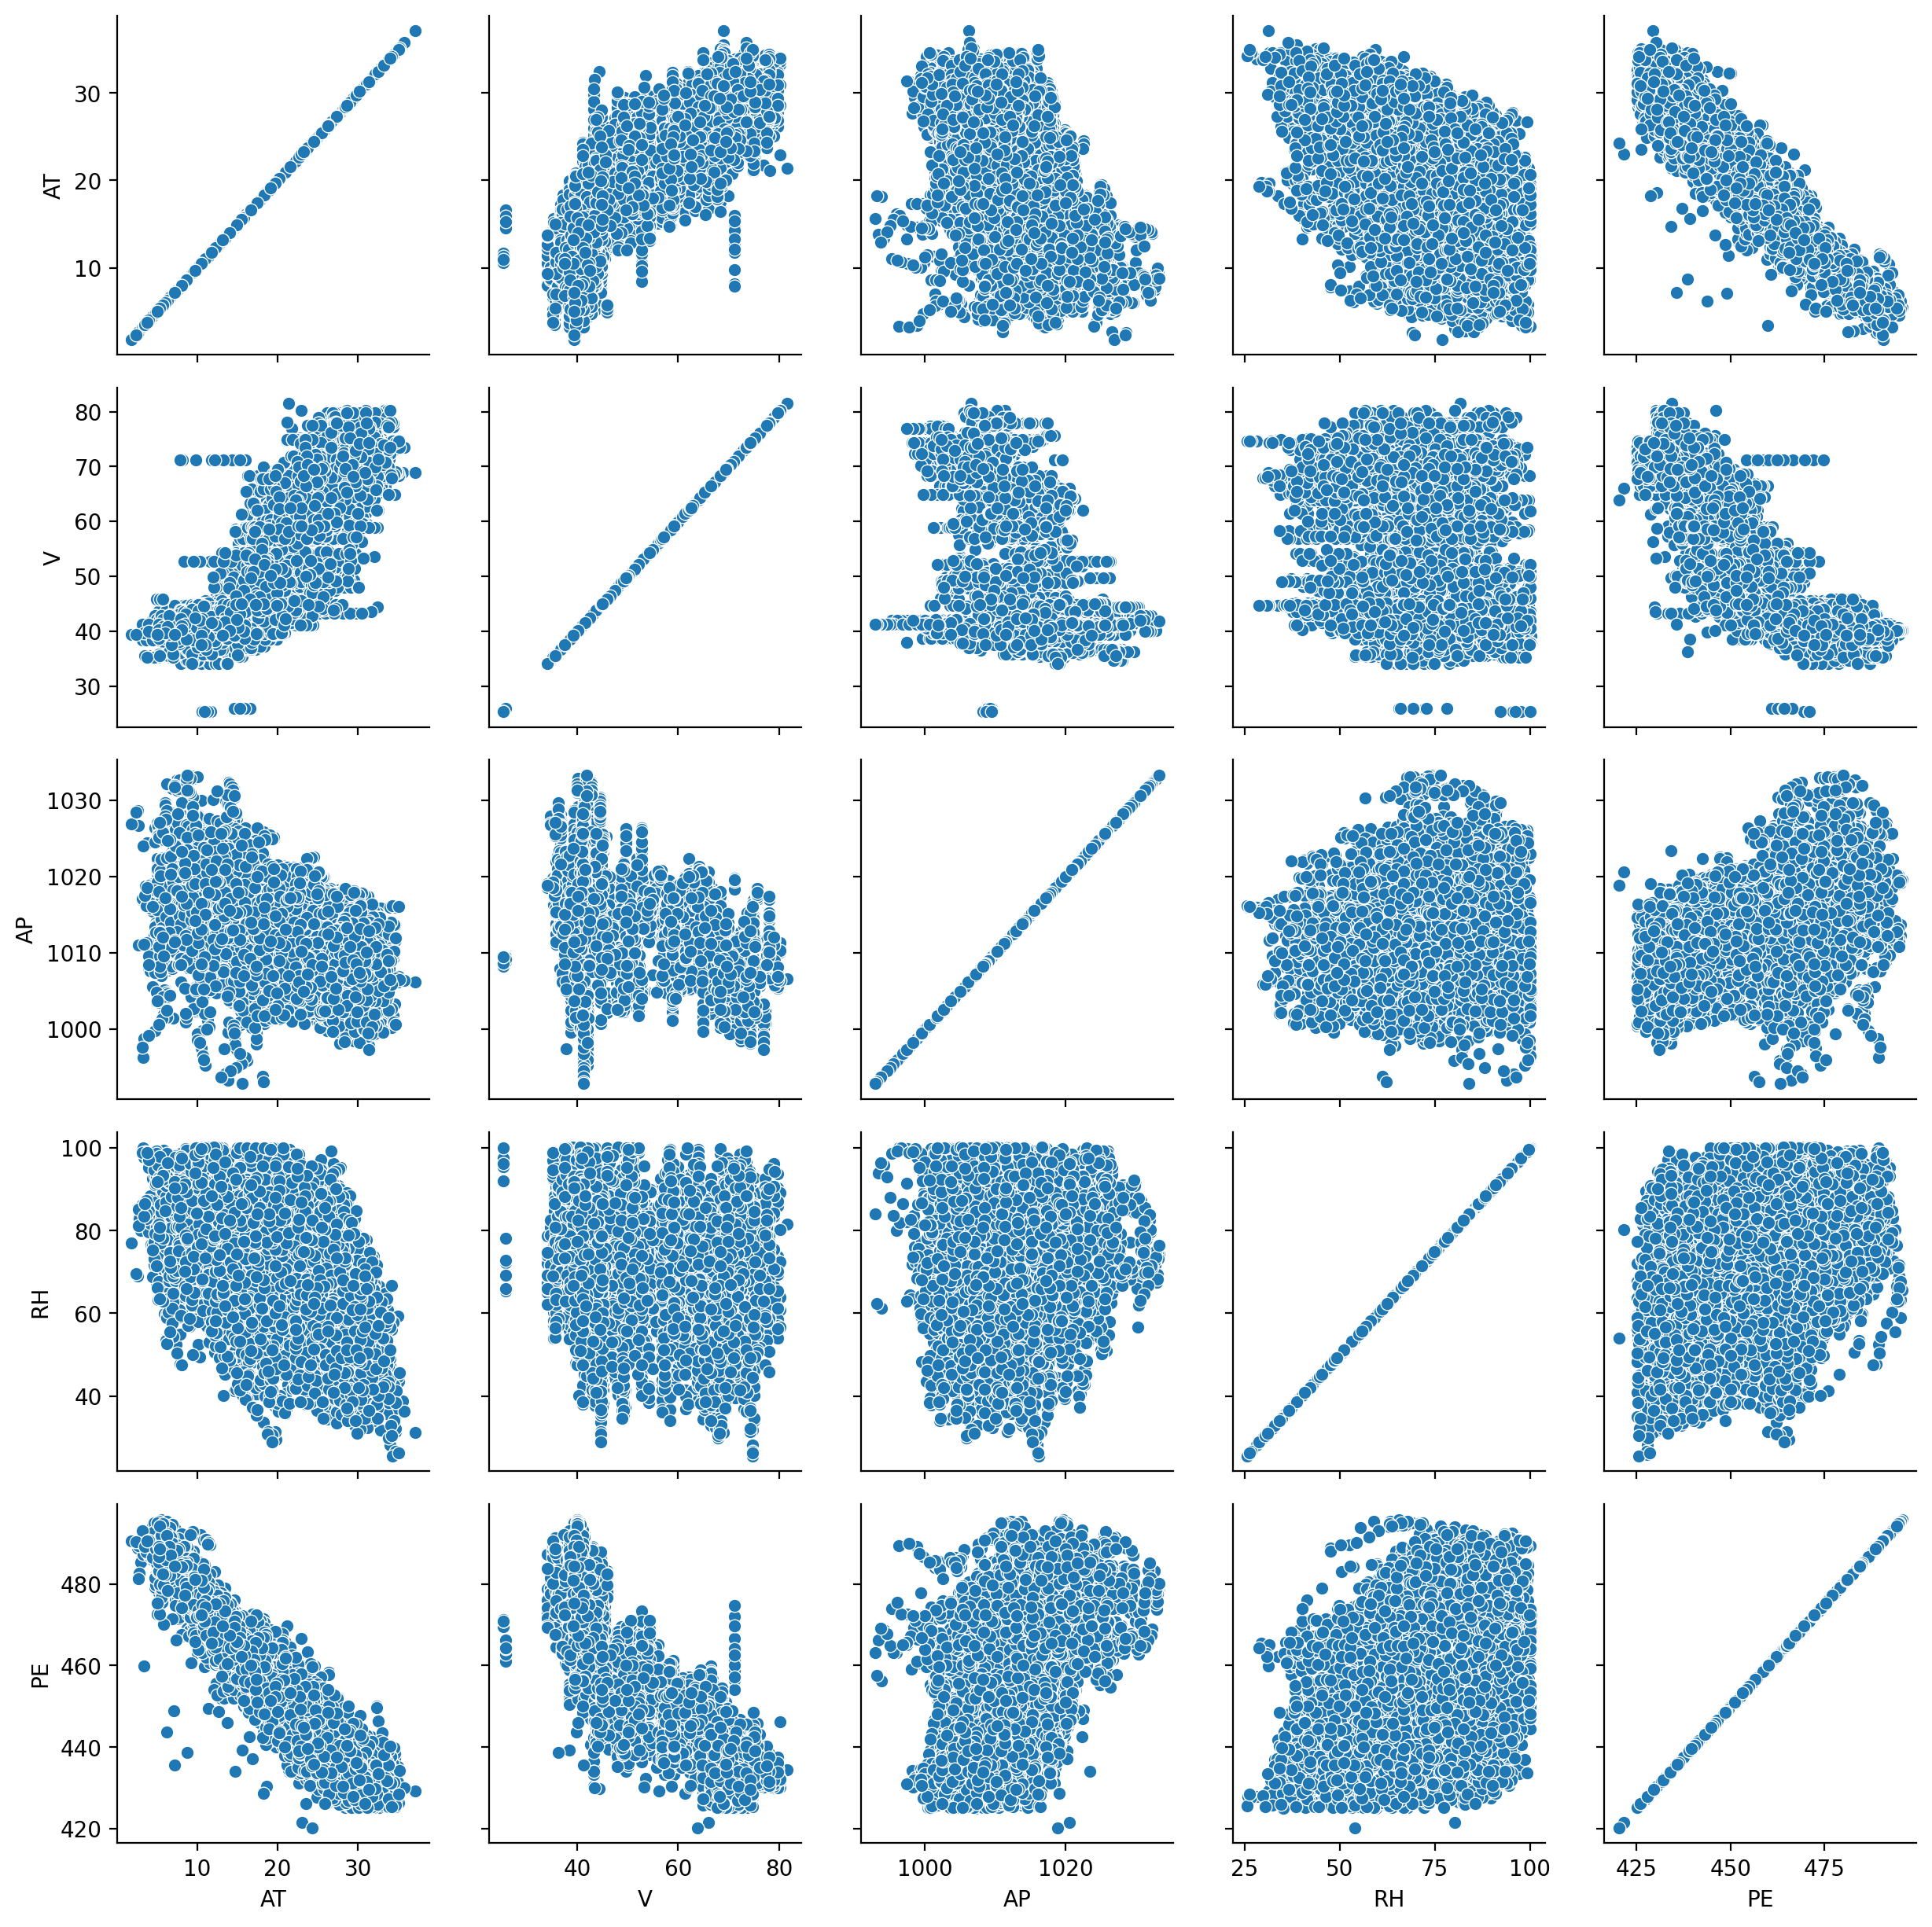

In [5]:
g = sns.PairGrid(data)
g.map(sns.scatterplot)

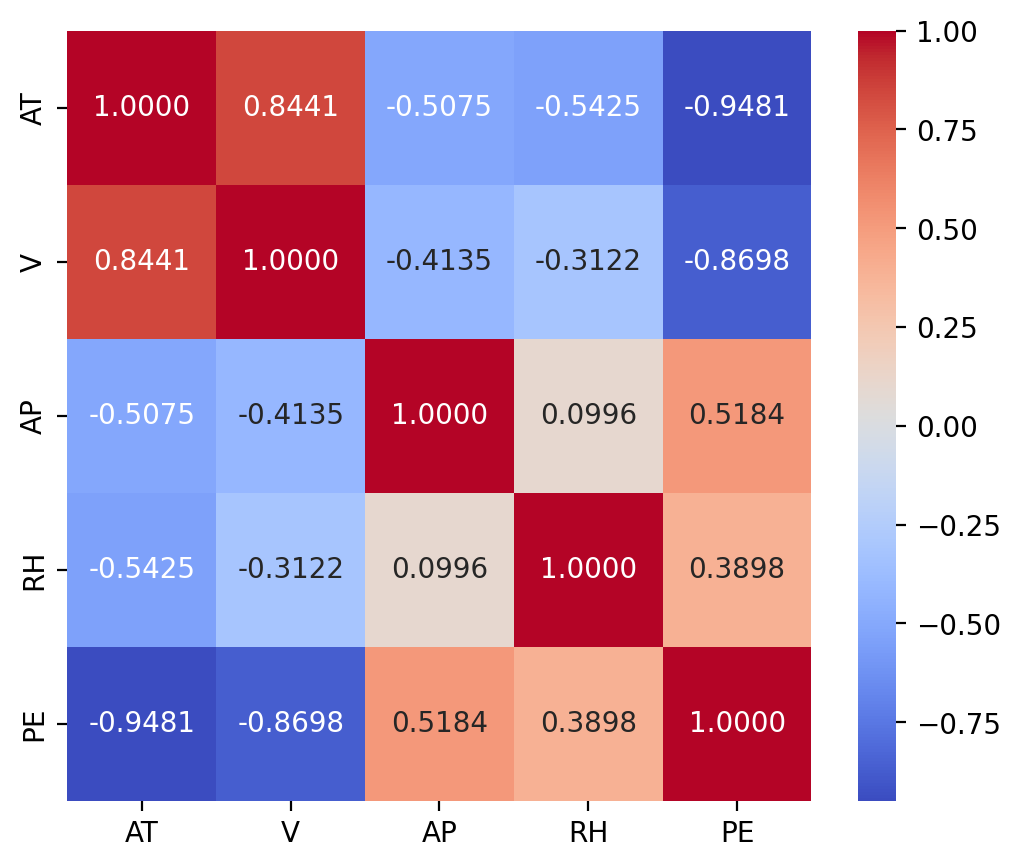

In [6]:
f, ax = plt.subplots(figsize = (6,5))
data_corr = data.corr()
sns.heatmap(
            round(data_corr,4),
            annot=True,
            cmap="coolwarm",
            fmt = '.4f',
            linewidth = 0
)
plt.savefig('correlacion.png')

# 4. Define x and y

In [7]:
x = data.drop(['PE'], axis = 1).values
y = data['PE'].values

In [8]:
print('x: \n', x)
print('y: \n', y)

x: 
 [[  14.96   41.76 1024.07   73.17]
 [  25.18   62.96 1020.04   59.08]
 [   5.11   39.4  1012.16   92.14]
 ...
 [  31.32   74.33 1012.92   36.48]
 [  24.48   69.45 1013.86   62.39]
 [  21.6    62.52 1017.23   67.87]]
y: 
 [463.26 444.37 488.56 ... 429.57 435.74 453.28]


# 5. Split the dataset in training set and test set, choose the scaling method and plot the coefficients Ridge and Lasso

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    train_size = 0.8,
                                                   random_state = 42)

In [10]:
# Pedir al usuario que elija entre MinMaxScaler, StandardScaler o ningun escalado
print("Seleccione el método de escalado:")
print("1. MinMaxScaler")
print("2. StandardScaler")
print("3. No aplicar ningún escalado")
opcion = input("Ingrese el número correspondiente al método deseado: ")

# Verificar la opción elegida por el usuario y realizar el escalado correspondiente
if opcion == "1":
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    print("Se ha aplicado MinMaxScaler.")
elif opcion == "2":
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    print("Se ha aplicado StandardScaler.")
elif opcion =="3":
    print("No se aplicará ningun escalado.")
else:
    print("Opción inválida. Por favor, seleccione 1,2 o 3 para elegir el método de escalado.")

Seleccione el método de escalado:
1. MinMaxScaler
2. StandardScaler
3. No aplicar ningún escalado


Ingrese el número correspondiente al método deseado:  2


Se ha aplicado StandardScaler.


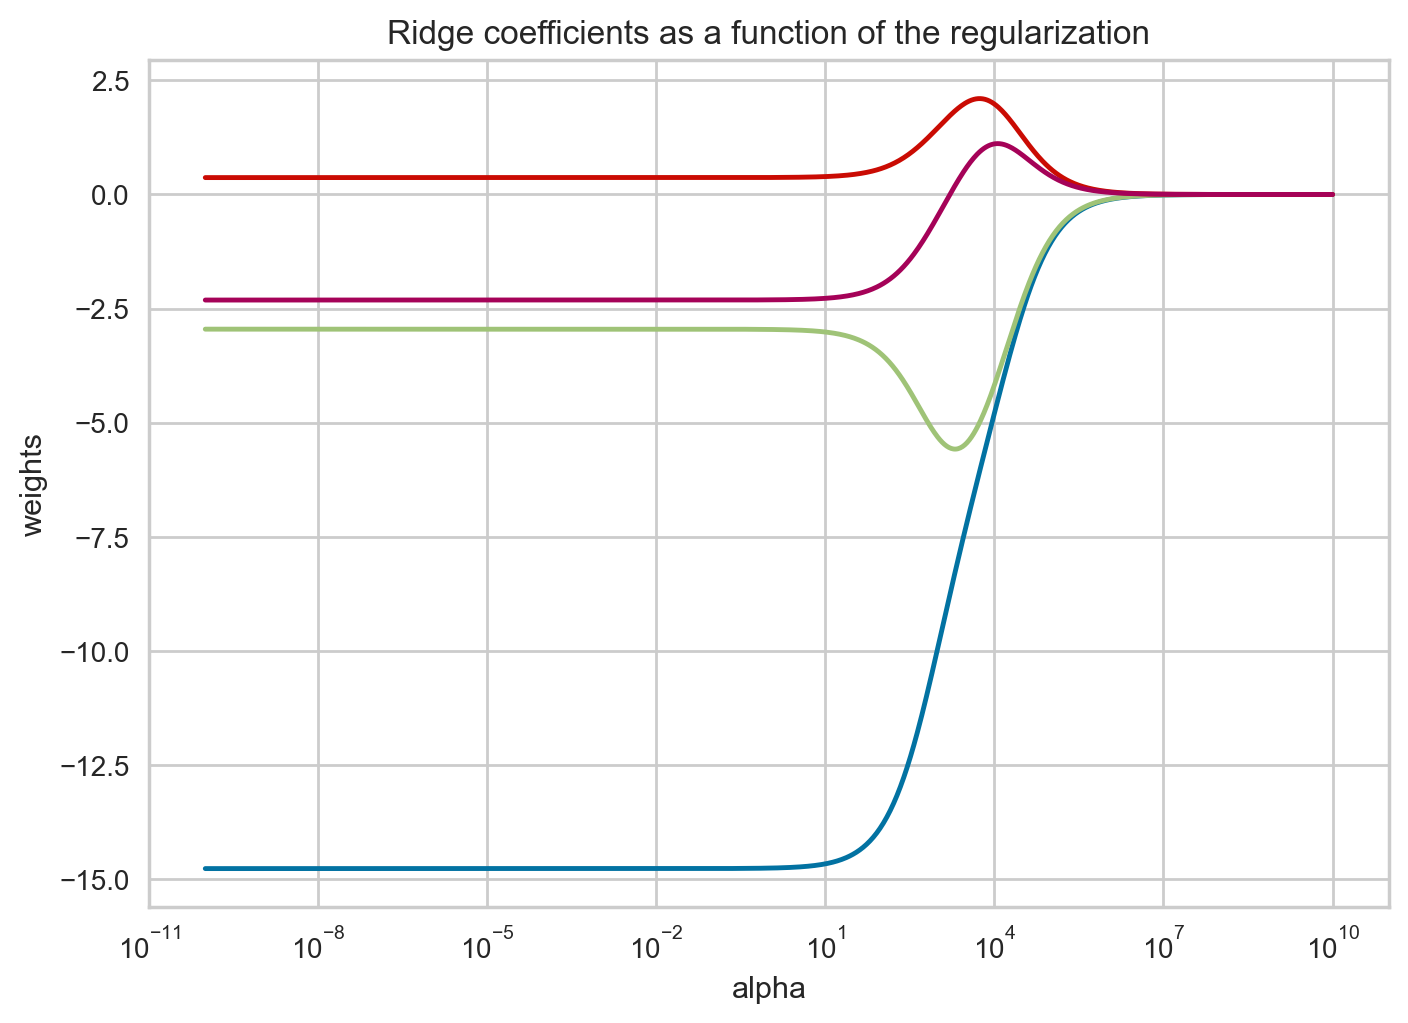

In [57]:
n_alphas = 1000
#alphas = np.logspace(-0.7, 6.5, n_alphas)
alphas = np.logspace(-10, 10, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::1])  # normal axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.savefig("lambda_ridge2.png")
plt.show()

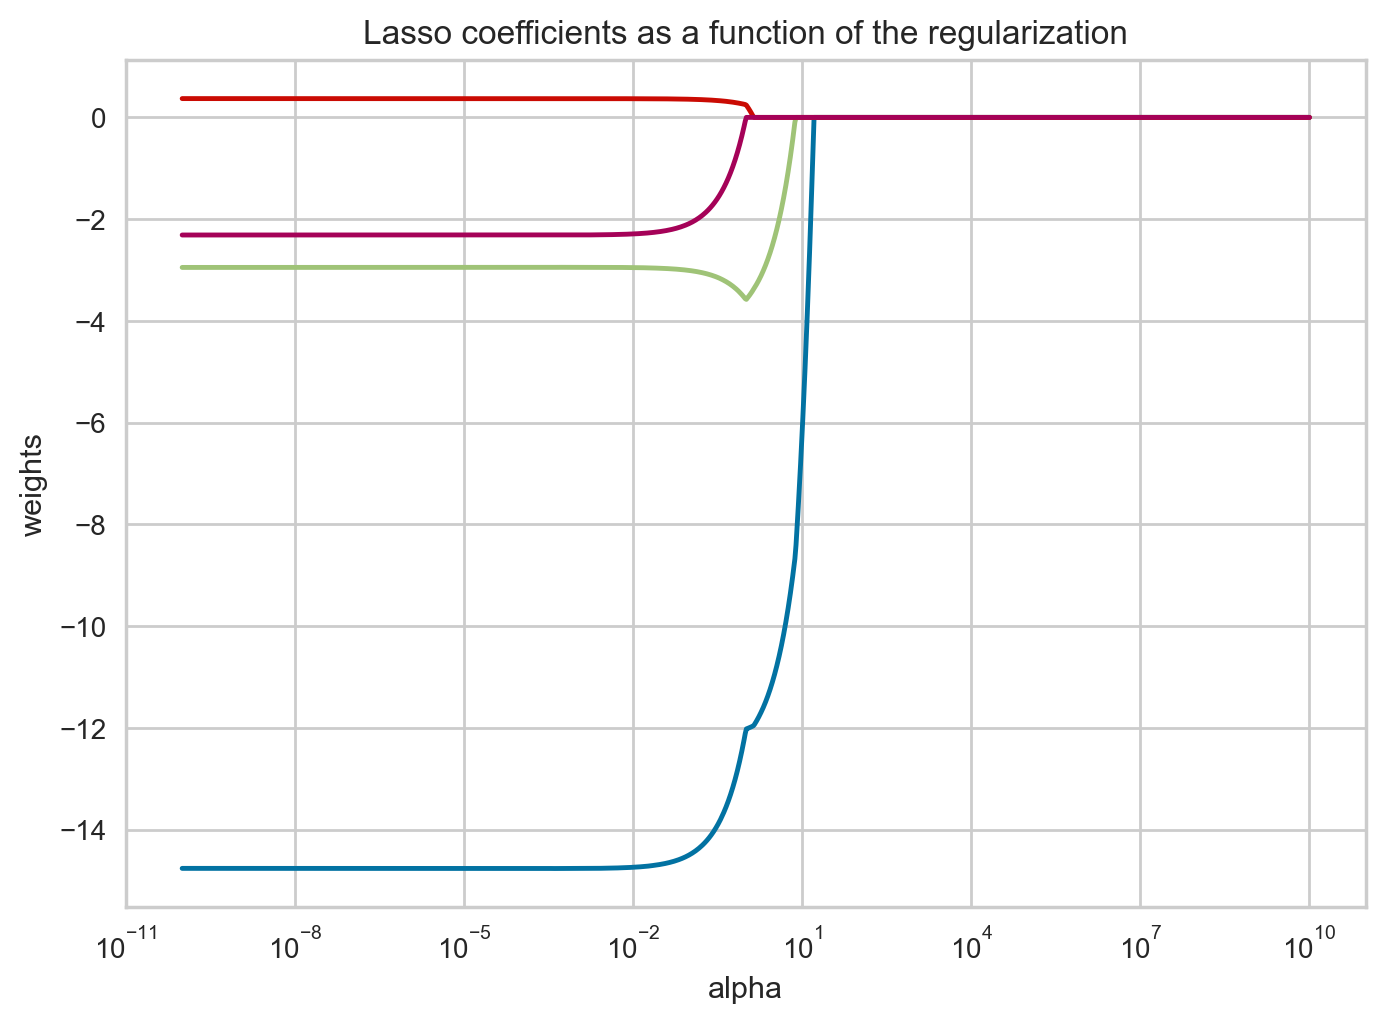

In [58]:
n_alphas = 1000
# alphas = np.logspace(-2, 1.3, n_alphas)
alphas = np.logspace(-10, 10, n_alphas)

coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::1])  # normal axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.savefig("lambda_lasso2.png")
plt.show()

In [13]:
print('Datos de train: \n', x_train[0:5,:])
print('Tamanio de los datos de train: ', x_train.shape)
print('.-----------------------------------------------------------.')
print('Datos de test: \n', x_test[0:5,:])
print('Tamanio de los datos de test: ', x_test.shape)

Datos de train: 
 [[ 0.30884304 -0.41258437 -0.66692982  1.04050751]
 [-1.14790306 -1.08849369  2.05467132  0.11116543]
 [-1.49762974 -1.15301588  1.31119314  0.98443242]
 [-1.10216957 -0.74621132  0.0294502   0.62267969]
 [-0.31528456 -1.12311535 -1.03698684  0.06192876]]
Tamanio de los datos de train:  (7654, 4)
.-----------------------------------------------------------.
Datos de test: 
 [[ 2.15965060e-03 -4.88122544e-01  2.61576872e-01  1.10481588e-01]
 [ 1.16163808e+00  1.17765165e+00 -4.11970498e-02 -2.13662517e+00]
 [ 1.12397521e+00  1.01555931e+00 -9.98299059e-01  1.33048393e-01]
 [ 1.21275198e+00  1.17765165e+00 -2.43762763e-02 -2.47649493e+00]
 [-1.38329602e+00 -1.27340485e+00  1.06056361e+00 -3.83252763e-01]]
Tamanio de los datos de test:  (1914, 4)


# **Section A: Regression Models**

# 6. Define $\lambda$

In [14]:
lambdas_ridge = np.logspace(-0.7, 6.5, 6000)
param_grid_ridge = {'alpha': lambdas_ridge.reshape(-1)} 
print('El mínimo es: ', np.min(lambdas_ridge))
print('El máximo es: ', np.max(lambdas_ridge))
print('Rejilla de valores posibles: \n' , param_grid_ridge)

El mínimo es:  0.19952623149688797
El máximo es:  3162277.6601683795
Rejilla de valores posibles: 
 {'alpha': array([1.99526231e-01, 2.00078397e-01, 2.00632091e-01, ...,
       3.14484757e+06, 3.15355057e+06, 3.16227766e+06])}


In [15]:
lambdas_lasso = np.logspace(-2, 1.3, 6000)
param_grid_lasso = {'alpha': lambdas_lasso.reshape(-1)} 
print('El mínimo es: ', np.min(lambdas_lasso))
print('El máximo es: ', np.max(lambdas_lasso))
print('Rejilla de valores posibles: \n' , param_grid_lasso)

El mínimo es:  0.01
El máximo es:  19.952623149688797
Rejilla de valores posibles: 
 {'alpha': array([1.00000000e-02, 1.00126744e-02, 1.00253648e-02, ...,
       1.99021418e+01, 1.99273665e+01, 1.99526231e+01])}


# 7. Define Ridge and Lasso Model

In [16]:
# Define the Ridge Regression Model
ridge = Ridge(fit_intercept=True, random_state = 42)

# Define the Lasso Regression Model
lasso = Lasso(fit_intercept=True, random_state = 42)

### 7.1 GridSearchCV for Ridge and Lasso

In [17]:
# Initialice GridSearchCV for Ridge
start_time_grid_search_ridge = time.time()
grid_search_ridge = GridSearchCV(estimator=ridge,
                                 param_grid=param_grid_ridge,
                                 cv=10,
                                 n_jobs = -1,
                                 verbose = 1,
                                 scoring=scorer)
# Fit model to train data
grid_search_ridge.fit(x_train, y_train)
# Get best lambda
best_lambda_grid_ridge = grid_search_ridge.best_params_['alpha']
best_score_grid_ridge = grid_search_ridge.best_score_
end_time_grid_search_ridge = time.time()
grid_search_ridge_execution_time = end_time_grid_search_ridge - start_time_grid_search_ridge

#------------------------------------------------------------------------------------------------------------------#

# Initialice GridSearchCV for Lasso
start_time_grid_search_lasso = time.time()
grid_search_lasso = GridSearchCV(estimator=lasso,
                                 param_grid=param_grid_lasso,
                                 cv=10,
                                 n_jobs = -1,
                                 verbose = 1,
                                 scoring=scorer)
# Fit model to train data
grid_search_lasso.fit(x_train, y_train)
# Get best lambda
best_lambda_grid_lasso = grid_search_lasso.best_params_['alpha']
best_score_grid_lasso = grid_search_lasso.best_score_

end_time_grid_search_lasso = time.time()
grid_search_lasso_execution_time = end_time_grid_search_lasso - start_time_grid_search_lasso

print("Execution time for find the best lambda for Ridge using GridSearchCV:", grid_search_ridge_execution_time, "segundos")
print("Execution time for find the best lambda for Lasso using GridSearchCV:", grid_search_lasso_execution_time, "segundos")

print("Best lambda found using GridSearchCV for Ridge:", best_lambda_grid_ridge)
print("Best lambda found using GridSearchCV for Lasso:", best_lambda_grid_lasso)

print("Best R squared score for Ridge with best lambda:", best_score_grid_ridge)
print("Best R squared score for Lasso with best lambda:", best_score_grid_lasso)

Fitting 10 folds for each of 6000 candidates, totalling 60000 fits
Fitting 10 folds for each of 6000 candidates, totalling 60000 fits
Execution time for find the best lambda for Ridge using GridSearchCV: 39.518171072006226 segundos
Execution time for find the best lambda for Lasso using GridSearchCV: 46.000826597213745 segundos
Best lambda found using GridSearchCV for Ridge: 0.758047842635104
Best lambda found using GridSearchCV for Lasso: 0.01
Best R squared score for Ridge with best lambda: 0.9281228902827838
Best R squared score for Lasso with best lambda: 0.9281219219568424


### 7.2 RandomizedSearchCV for Ridge and Lasso

In [18]:
# Initialice RandomizedSearchCV for Ridge
start_time_random_search_ridge = time.time()
random_search_ridge = RandomizedSearchCV(estimator=ridge,
                                         param_distributions=param_grid_ridge,
                                         n_iter=100,
                                         cv=10,
                                         n_jobs = -1,
                                         verbose = 1,
                                         random_state = 0)
# Fit model to train data
random_search_ridge.fit(x_train, y_train)
# Get best lambda 
best_lambda_random_ridge = random_search_ridge.best_params_['alpha']
best_score_random_ridge = random_search_ridge.best_score_
end_time_random_search_ridge = time.time()
random_search_ridge_execution_time = end_time_random_search_ridge - start_time_random_search_ridge

#------------------------------------------------------------------------------------------------------------------#

# Initialice RandomizedSearchCV for Lasso
start_time_random_search_lasso = time.time()
random_search_lasso = RandomizedSearchCV(estimator=lasso,
                                         param_distributions=param_grid_lasso,
                                         n_iter=100,
                                         cv=10,
                                        n_jobs = -1,
                                        verbose = 1,
                                        random_state = 0)
# Fit model to train data
random_search_lasso.fit(x_train, y_train)
# Get best lambda 
best_lambda_random_lasso = random_search_lasso.best_params_['alpha']
best_score_random_lasso = random_search_lasso.best_score_
end_time_random_search_lasso = time.time()
random_search_lasso_execution_time = end_time_random_search_lasso - start_time_random_search_lasso

print("Execution time for find the best lambda for Ridge using RandomizedSearchCV:", random_search_ridge_execution_time, "segundos")
print("Execution time for find the best lambda for Lasso using RandomizedSearchCV:", random_search_lasso_execution_time, "segundos")

print("Best lambda found using RandomizedSearchCV for Ridge:", best_lambda_random_ridge)
print("Best lambda found using RandomizedSearchCV for lasso:", best_lambda_random_lasso)

print("Best R squared score for Ridge with best lambda:", best_score_random_ridge)
print("Best R squared score for Lasso with best lambda:", best_score_random_lasso)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Execution time for find the best lambda for Ridge using RandomizedSearchCV: 1.0472865104675293 segundos
Execution time for find the best lambda for Lasso using RandomizedSearchCV: 1.2570254802703857 segundos
Best lambda found using RandomizedSearchCV for Ridge: 0.7353505400985709
Best lambda found using RandomizedSearchCV for lasso: 0.010153156962070463
Best R squared score for Ridge with best lambda: 0.9281228902428873
Best R squared score for Lasso with best lambda: 0.9281218856972042


### 7.3 HalvingGridSearchCV for Ridge and Lasso

In [19]:
# Initialice HalvingGridSearchCV for Ridge
start_time_halving_search_ridge = time.time()
halving_search_ridge = HalvingGridSearchCV(estimator=ridge,
                                           param_grid=param_grid_ridge,
                                           cv=10,
                                           factor=3,
                                          random_state = 0,
                                          n_jobs = -1,
                                          verbose = 1)
# Fit model to train data
halving_search_ridge.fit(x_train, y_train)
# Get best lambda
best_lambda_halving_ridge = halving_search_ridge.best_params_['alpha']
best_score_halving_ridge = halving_search_ridge.best_score_
end_time_halving_search_ridge = time.time()
halving_search_ridge_execution_time = end_time_halving_search_ridge - start_time_halving_search_ridge

#------------------------------------------------------------------------------------------------------------------#

# Initialice HalvingGridSearchCV for Lasso
start_time_halving_search_lasso = time.time()
halving_search_lasso = HalvingGridSearchCV(estimator=lasso,
                                           param_grid=param_grid_lasso,
                                           cv=10,
                                           factor=3,
                                          random_state = 0,
                                          n_jobs = -1,
                                          verbose = 1)
# Fit model to train data
halving_search_lasso.fit(x_train, y_train)
# Get best lambda
best_lambda_halving_lasso = halving_search_lasso.best_params_['alpha']
best_score_halving_lasso = halving_search_lasso.best_score_
end_time_halving_search_lasso = time.time()
halving_search_lasso_execution_time = end_time_halving_search_lasso - start_time_halving_search_lasso

print("Execution time for find the best lambda for Ridge using HalvingGridSearchCV:", halving_search_ridge_execution_time, "segundos")
print("Execution time for find the best lambda for Lasso using HalvingGridSearchCV:", halving_search_lasso_execution_time, "segundos")

print("Best lambda found using HalvingGridSearchCV for Ridge:", best_lambda_halving_ridge)
print("Best lambda found using HalvingGridSearchCV for Lasso:", best_lambda_halving_lasso)

print("Best R squared score for Ridge with best lambda:", best_score_halving_ridge)
print("Best R squared score for Lasso with best lambda:", best_score_halving_lasso)

n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 20
max_resources_: 7654
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6000
n_resources: 20
Fitting 10 folds for each of 6000 candidates, totalling 60000 fits
----------
iter: 1
n_candidates: 2000
n_resources: 60
Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
----------
iter: 2
n_candidates: 667
n_resources: 180
Fitting 10 folds for each of 667 candidates, totalling 6670 fits
----------
iter: 3
n_candidates: 223
n_resources: 540
Fitting 10 folds for each of 223 candidates, totalling 2230 fits
----------
iter: 4
n_candidates: 75
n_resources: 1620
Fitting 10 folds for each of 75 candidates, totalling 750 fits
----------
iter: 5
n_candidates: 25
n_resources: 4860
Fitting 10 folds for each of 25 candidates, totalling 250 fits
n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 20
max_resources_: 7654
aggressive_elimination: False
fact

# 8. Create best models for Ridge and Lasso

In [20]:
# Create best models
ridge_grid = Ridge(alpha=best_lambda_grid_ridge, fit_intercept = True)
ridge_random = Ridge(alpha=best_lambda_random_ridge, fit_intercept = True)
ridge_halving = Ridge(alpha=best_lambda_halving_ridge, fit_intercept = True)

lasso_grid = Lasso(alpha=best_lambda_grid_lasso, fit_intercept = True)
lasso_random = Lasso(alpha=best_lambda_random_lasso, fit_intercept = True)
lasso_halving = Lasso(alpha=best_lambda_halving_lasso, fit_intercept = True)

# Fit model to train data (Ridge case)
ridge_grid.fit(x_train, y_train)
ridge_random.fit(x_train, y_train)
ridge_halving.fit(x_train, y_train)

# Fit model to train data (Lasso case)
lasso_grid.fit(x_train, y_train)
lasso_random.fit(x_train, y_train)
lasso_halving.fit(x_train, y_train)

Lasso(alpha=0.08002958074821419)

# 8.1 Coefficients and intercept for Ridge in every case

In [21]:
# Get coef and intercept for Ridge in every case

# Case i) GridSearchCV
ridge_grid_beta = ridge_grid.coef_
ridge_grid_intercept = ridge_grid.intercept_
print("Coefficients for Ridge found by GridSearchCV:")
print("Lambda value:", best_lambda_grid_ridge)
print("Coefficients:", ridge_grid_beta)
print("Intercept:", ridge_grid_intercept)
print("------------------------------------------------------------------")

# Case ii) RandomizedSearchCV
ridge_random_beta = ridge_random.coef_
ridge_random_intercept = ridge_random.intercept_
print("Coefficients for Ridge found by RandomizedSearchCV:")
print("Lambda value:", best_lambda_random_ridge)
print("Coefficients:", ridge_random_beta)
print("Intercept:", ridge_random_intercept)
print("------------------------------------------------------------------")

# Case iii) HalvingGridSearchCV
ridge_halving_beta = ridge_halving.coef_
ridge_halving_intercept = ridge_halving.intercept_
print("Coefficients for Ridge found by HalvingGridSearchCV:")
print("Lambda value:", best_lambda_halving_ridge)
print("Coefficients:", ridge_halving_beta)
print("Intercept:", ridge_halving_intercept)
print("------------------------------------------------------------------")

Coefficients for Ridge found by GridSearchCV:
Lambda value: 0.758047842635104
Coefficients: [-14.75598414  -2.95444413   0.37147455  -2.30931919]
Intercept: 454.4310399790958
------------------------------------------------------------------
Coefficients for Ridge found by RandomizedSearchCV:
Lambda value: 0.7353505400985709
Coefficients: [-14.75622176  -2.9543002    0.37142386  -2.30940524]
Intercept: 454.4310399790958
------------------------------------------------------------------
Coefficients for Ridge found by HalvingGridSearchCV:
Lambda value: 1.5767020233251103
Coefficients: [-14.7474222   -2.95962903   0.37330104  -2.30621828]
Intercept: 454.4310399790958
------------------------------------------------------------------


# 8.2 Coefficients and intercept for Lasso in every case

In [22]:
# Get coef and intercept for Lasso in every case

# Case i) GridSearchCV
lasso_grid_beta = lasso_grid.coef_
lasso_grid_intercept = lasso_grid.intercept_
print("Coefficients for Lasso found by GridSearchCV:")
print("Lambda value:", best_lambda_grid_lasso)
print("Coefficients:", lasso_grid_beta)
print("Intercept:", lasso_grid_intercept)
print("------------------------------------------------------------------")

# Case ii) RandomizedSearchCV
lasso_random_beta = lasso_random.coef_
lasso_random_intercept = lasso_random.intercept_
print("Coefficients for Lasso found by RandomizedSearchCV:")
print("Lambda value:", best_lambda_random_lasso)
print("Coefficients:", lasso_random_beta)
print("Intercept:", lasso_random_intercept)
print("------------------------------------------------------------------")

# Case iii) HalvingGridSearchCV
lasso_halving_beta = lasso_halving.coef_
lasso_halving_intercept = lasso_halving.intercept_
print("Coefficients for Lasso found by HalvingGridSearchCV:")
print("Lambda value:", best_lambda_halving_lasso)
print("Coefficients:", lasso_halving_beta)
print("Intercept:", lasso_halving_intercept)
print("------------------------------------------------------------------")

Coefficients for Lasso found by GridSearchCV:
Lambda value: 0.01
Coefficients: [-14.74255394  -2.95245953   0.36735695  -2.2912216 ]
Intercept: 454.4310399790958
------------------------------------------------------------------
Coefficients for Lasso found by RandomizedSearchCV:
Lambda value: 0.010153156962070463
Coefficients: [-14.74213838  -2.95255597   0.36733867  -2.29087088]
Intercept: 454.4310399790958
------------------------------------------------------------------
Coefficients for Lasso found by HalvingGridSearchCV:
Lambda value: 0.08002958074821419
Coefficients: [-14.55133025  -2.99728942   0.35925754  -2.13045021]
Intercept: 454.4310399790958
------------------------------------------------------------------


# 9. Evaluate the model

In [23]:
# Function to evaluate the model
def evaluate_model(model, x_data, y_data):
    y_pred = model.predict(x_data)
    r2 = r2_score(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    return r2, mse

In [24]:
# Evaluate the model in train data for Ridge
r2_train_grid_ridge, mse_train_grid_ridge = evaluate_model(ridge_grid, x_train, y_train)
r2_train_random_ridge, mse_train_random_ridge = evaluate_model(ridge_random, x_train, y_train)
r2_train_halving_ridge, mse_train_halving_ridge = evaluate_model(ridge_halving, x_train, y_train)

# Evaluate the model in train data for Lasso
r2_train_grid_lasso, mse_train_grid_lasso = evaluate_model(lasso_grid, x_train, y_train)
r2_train_random_lasso, mse_train_random_lasso = evaluate_model(lasso_random, x_train, y_train)
r2_train_halving_lasso, mse_train_halving_lasso = evaluate_model(lasso_halving, x_train, y_train)

In [25]:
print("R^2 and MSE on training set for Ridge:")
print("GridSearchCV - R^2:", r2_train_grid_ridge, "MSE:", mse_train_grid_ridge)
print("RandomizedSearchCV - R^2:", r2_train_random_ridge, "MSE:", mse_train_random_ridge)
print("HalvingGridSearchCV - R^2:", r2_train_halving_ridge, "MSE:", mse_train_halving_ridge)

print("------------------------------------------------------------------------------------------")

print("R^2 and MSE on training set for Lasso:")
print("GridSearchCV - R^2:", r2_train_grid_lasso, "MSE:", mse_train_grid_lasso)
print("RandomizedSearchCV - R^2:", r2_train_random_lasso, "MSE:", mse_train_random_lasso)
print("HalvingGridSearchCV - R^2:", r2_train_halving_lasso, "MSE:", mse_train_halving_lasso)

R^2 and MSE on training set for Ridge:
GridSearchCV - R^2: 0.9283315085334677 MSE: 20.893417207266022
RandomizedSearchCV - R^2: 0.9283315107160327 MSE: 20.893416570985842
HalvingGridSearchCV - R^2: 0.9283313856651567 MSE: 20.893453026896516
------------------------------------------------------------------------------------------
R^2 and MSE on training set for Lasso:
GridSearchCV - R^2: 0.9283301901745825 MSE: 20.893801546627046
RandomizedSearchCV - R^2: 0.92833014575662 MSE: 20.89381449573487
HalvingGridSearchCV - R^2: 0.9282341556034495 MSE: 20.921798373683764


In [26]:
# Evaluate the model in test data for Ridge
r2_test_grid_ridge, mse_test_grid_ridge = evaluate_model(ridge_grid, x_test, y_test)
r2_test_random_ridge, mse_test_random_ridge = evaluate_model(ridge_random, x_test, y_test)
r2_test_halving_ridge, mse_test_halving_ridge = evaluate_model(ridge_halving, x_test, y_test)

# Evaluate the model in test data for Lasso
r2_test_grid_lasso, mse_test_grid_lasso = evaluate_model(lasso_grid, x_test, y_test)
r2_test_random_lasso, mse_test_random_lasso = evaluate_model(lasso_random, x_test, y_test)
r2_test_halving_lasso, mse_test_halving_lasso = evaluate_model(lasso_halving, x_test, y_test)

In [27]:
print("\nR^2 and MSE on test set for Ridge:")
print("GridSearchCV - R^2:", r2_test_grid_ridge, "MSE:", mse_test_grid_ridge)
print("RandomizedSearchCV - R^2:", r2_test_random_ridge, "MSE:", mse_test_random_ridge)
print("HalvingGridSearchCV - R^2:", r2_test_halving_ridge, "MSE:", mse_test_halving_ridge)

print("------------------------------------------------------------------------------------------")

print("\nR^2 and MSE on test set for Lasso:")
print("GridSearchCV - R^2:", r2_test_grid_lasso, "MSE:", mse_test_grid_lasso)
print("RandomizedSearchCV - R^2:", r2_test_random_lasso, "MSE:", mse_test_random_lasso)
print("HalvingGridSearchCV - R^2:", r2_test_halving_lasso, "MSE:", mse_test_halving_lasso)


R^2 and MSE on test set for Ridge:
GridSearchCV - R^2: 0.9301075588003339 MSE: 20.272860305447573
RandomizedSearchCV - R^2: 0.9301074726557547 MSE: 20.272885292370205
HalvingGridSearchCV - R^2: 0.9301106184496003 MSE: 20.27197282976214
------------------------------------------------------------------------------------------

R^2 and MSE on test set for Lasso:
GridSearchCV - R^2: 0.9301152423128536 MSE: 20.270631641327498
RandomizedSearchCV - R^2: 0.9301154156713342 MSE: 20.27058135731683
HalvingGridSearchCV - R^2: 0.9301174313994701 MSE: 20.26999667928565


In [28]:
# Case i) Ridge
# Create a dictionary for evry r square test
ridge_results_r2 = {
    'r2_test_grid_ridge': r2_test_grid_ridge,
    'r2_test_random_ridge': r2_test_random_ridge,
    'r2_test_halving_ridge': r2_test_halving_ridge
}
# Create a dictionary for evry mse test
ridge_results_mse = {
    'mse_test_grid_ridge': mse_test_grid_ridge,
    'mse_test_random_ridge': mse_test_random_ridge,
    'mse_test_halving_ridge': mse_test_halving_ridge
}

# Find the maximum value
ridge_best_r2_name = max(ridge_results_r2, key=ridge_results_r2.get)
ridge_best_r2 = ridge_results_r2[ridge_best_r2_name]

# Find the minimum value
ridge_best_mse_name = min(ridge_results_mse, key=ridge_results_mse.get)
ridge_best_mse = ridge_results_mse[ridge_best_mse_name]

print(f"El máximo es {ridge_best_r2} correspondiente a {ridge_best_r2_name}")
print(f"El mínimo es {ridge_best_mse} correspondiente a {ridge_best_mse_name}")

El máximo es 0.9301106184496003 correspondiente a r2_test_halving_ridge
El mínimo es 20.27197282976214 correspondiente a mse_test_halving_ridge


In [29]:
# Case ii) Lasso
# Create a dictionary for evry r square test
lasso_results_r2 = {
    'r2_test_grid_lasso': r2_test_grid_lasso,
    'r2_test_random_lasso': r2_test_random_lasso,
    'r2_test_halving_lasso': r2_test_halving_lasso
}
# Create a dictionary for evry mse test
lasso_results_mse = {
    'mse_test_grid_lasso': mse_test_grid_lasso,
    'mse_test_random_lasso': mse_test_random_lasso,
    'mse_test_halving_lasso': mse_test_halving_lasso
}

# Find the maximum value
lasso_best_r2_name = max(lasso_results_r2, key=lasso_results_r2.get)
lasso_best_r2 = lasso_results_r2[lasso_best_r2_name]

# Find the minimum value
lasso_best_mse_name = min(lasso_results_mse, key=lasso_results_mse.get)
lasso_best_mse = lasso_results_mse[lasso_best_mse_name]

print(f"El máximo es {lasso_best_r2} correspondiente a {lasso_best_r2_name}")
print(f"El mínimo es {lasso_best_mse} correspondiente a {lasso_best_mse_name}")

El máximo es 0.9301174313994701 correspondiente a r2_test_halving_lasso
El mínimo es 20.26999667928565 correspondiente a mse_test_halving_lasso


# 10. Predictions Graphs

# 10.1 Predictions with Ridge Models

In [30]:
y_pred_ridge_grid    = ridge_grid.predict(x_test)
y_pred_ridge_random  = ridge_random.predict(x_test)
y_pred_ridge_halving = ridge_halving.predict(x_test)

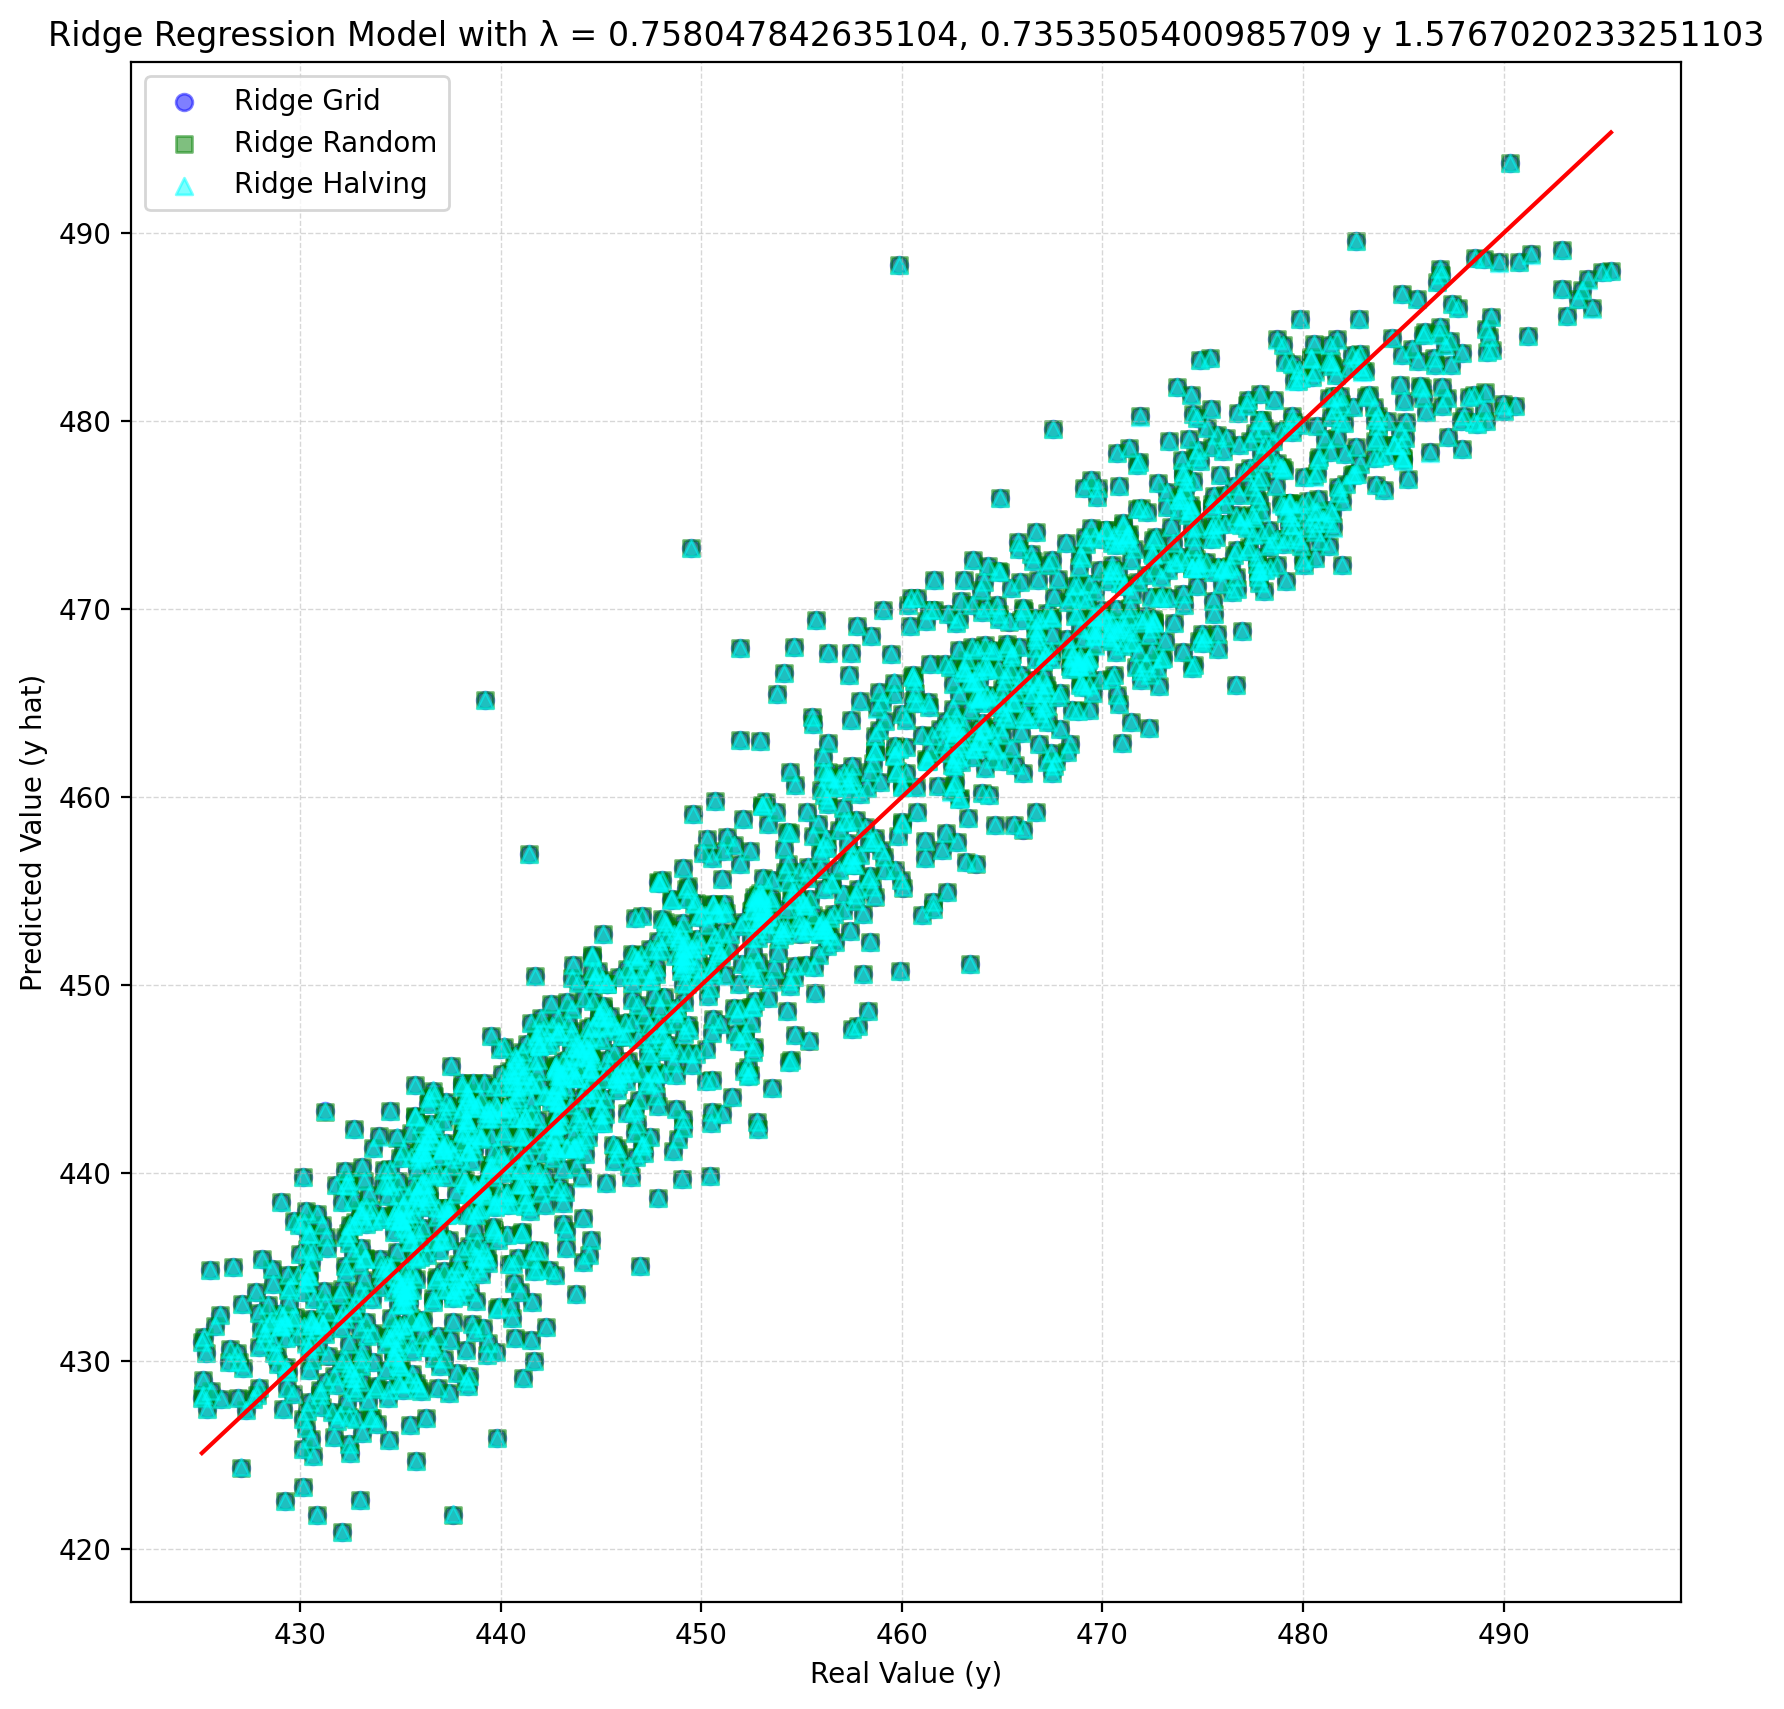

In [31]:
x = np.linspace(min(y_test), max(y_test), 500)
plt.figure(figsize = (10,10))
plt.scatter(y_test, y_pred_ridge_grid, color='blue', alpha=0.5, marker='o', label='Ridge Grid')
plt.scatter(y_test, y_pred_ridge_random, color='green', alpha=0.5, marker='s', label='Ridge Random')
plt.scatter(y_test, y_pred_ridge_halving, color='cyan', alpha=0.5, marker='^', label='Ridge Halving')
plt.plot(x,x, color = 'red')
plt.xlabel('Real Value (y)')
plt.ylabel('Predicted Value (y hat)')
plt.title(f'Ridge Regression Model with \u03BB = {best_lambda_grid_ridge}, {best_lambda_random_ridge} y {best_lambda_halving_ridge}')
plt.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend()

plt.savefig('ridge2.png')

# 10.2 Predictions with Lasso Models

In [32]:
y_pred_lasso_grid    = lasso_grid.predict(x_test)
y_pred_lasso_random  = lasso_random.predict(x_test)
y_pred_lasso_halving = lasso_halving.predict(x_test)

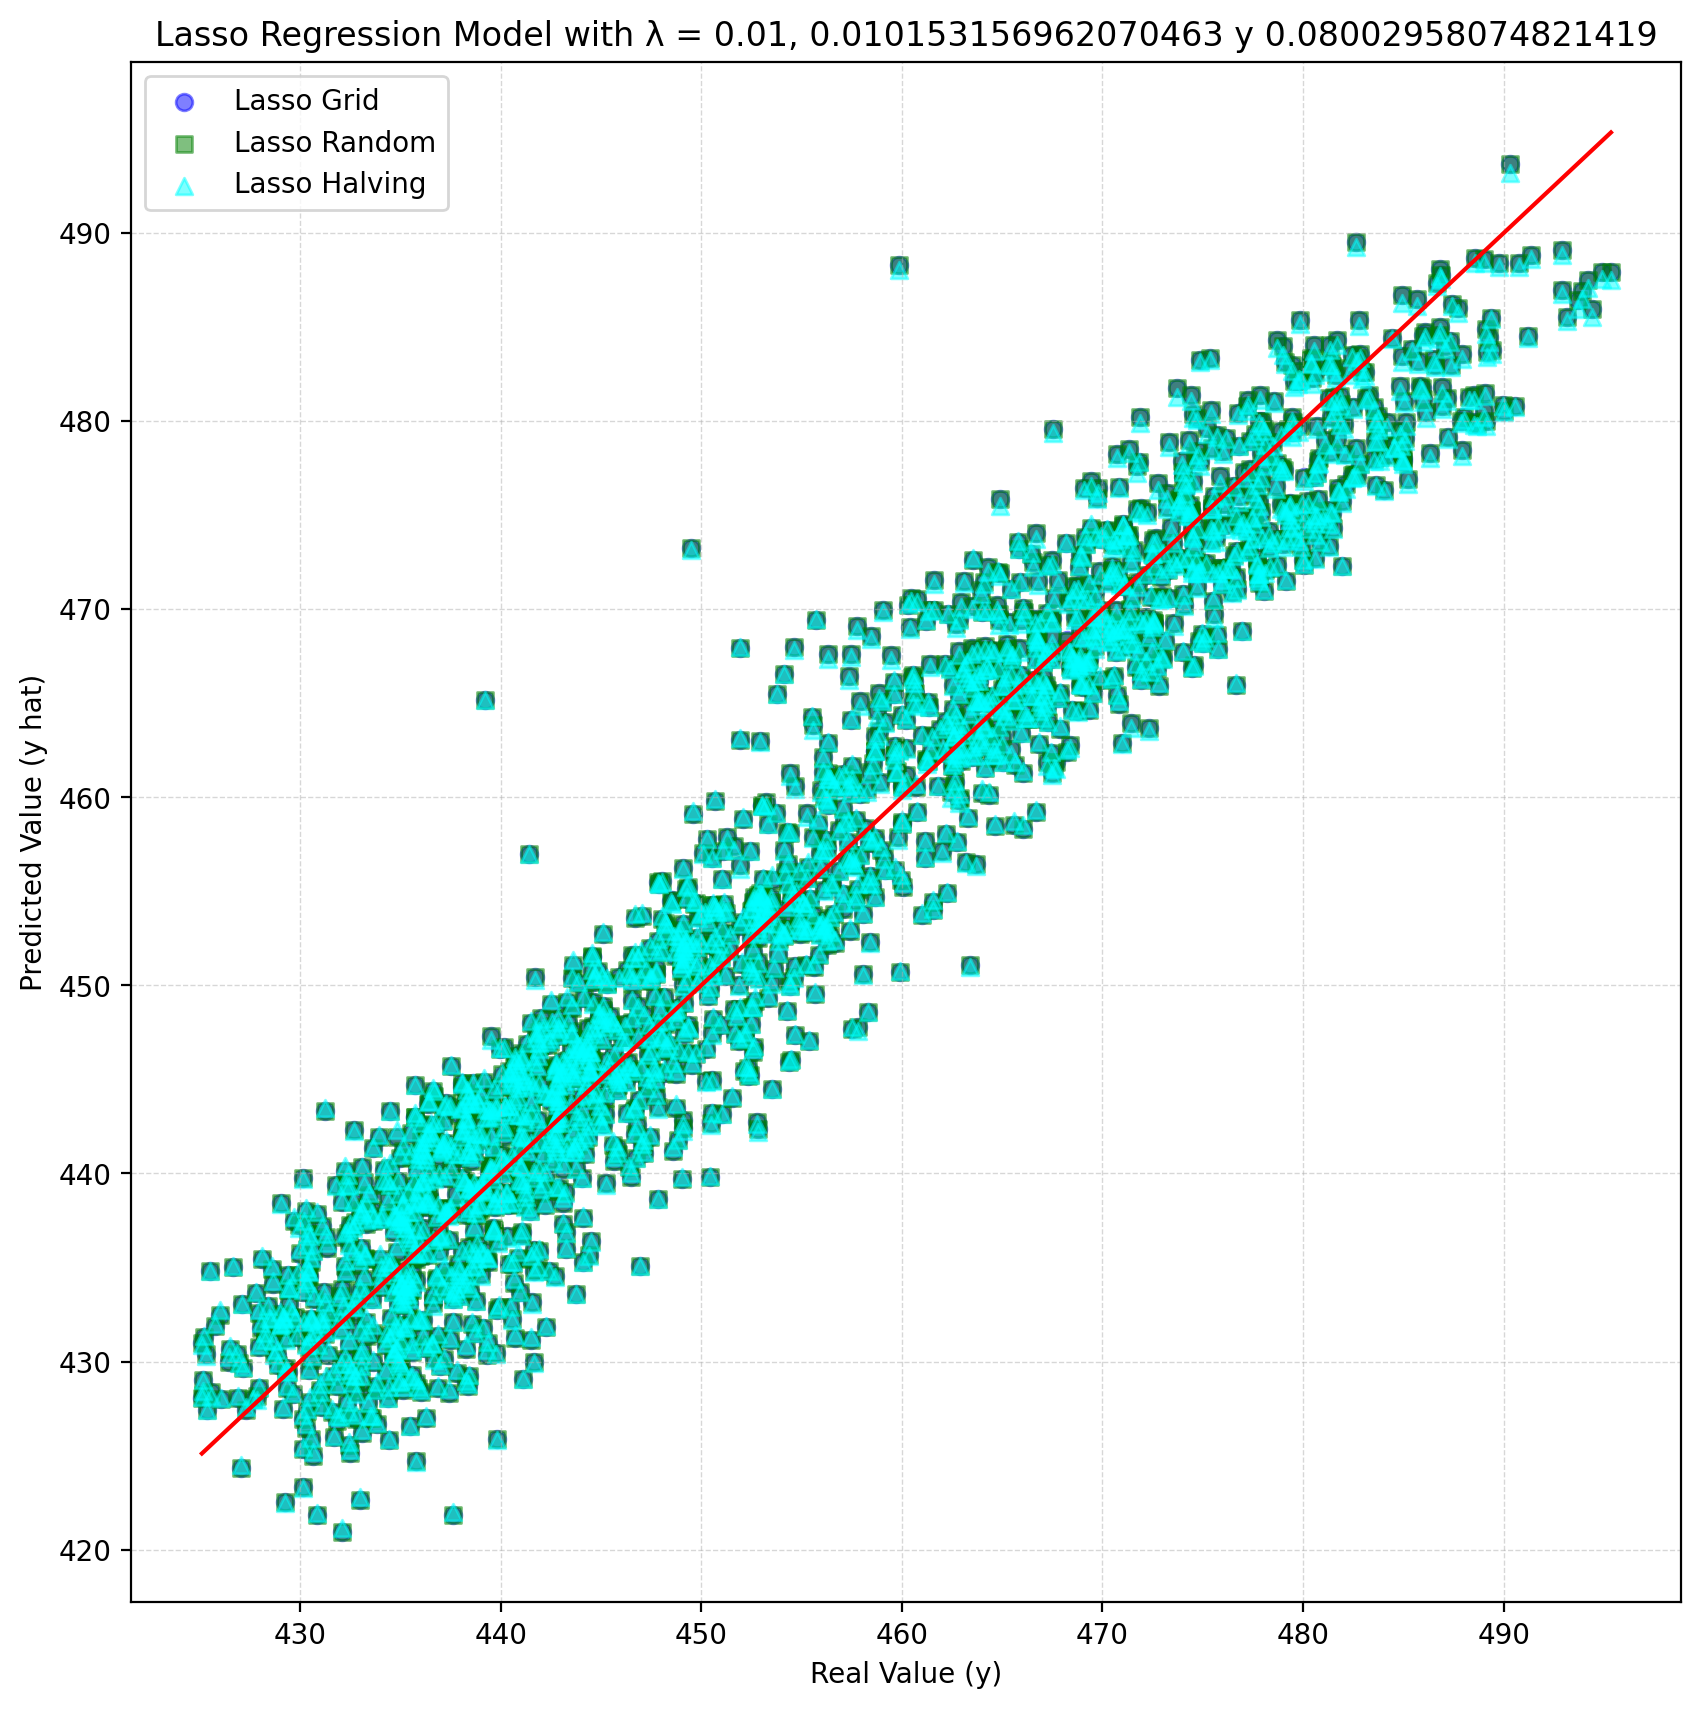

In [33]:
x = np.linspace(min(y_test), max(y_test), 500)
plt.figure(figsize = (10,10))
plt.scatter(y_test, y_pred_lasso_grid, color='blue', alpha=0.5, marker='o', label='Lasso Grid')
plt.scatter(y_test, y_pred_lasso_random, color='green', alpha=0.5, marker='s', label='Lasso Random')
plt.scatter(y_test, y_pred_lasso_halving, color='cyan', alpha=0.5, marker='^', label='Lasso Halving')
plt.plot(x,x, color = 'red')
plt.xlabel('Real Value (y)')
plt.ylabel('Predicted Value (y hat)')
plt.title(f'Lasso Regression Model with \u03BB = {best_lambda_grid_lasso}, {best_lambda_random_lasso} y {best_lambda_halving_lasso}')
plt.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend()

plt.savefig('lasso2.png')

# **Section B: AutoKeras Model**

# 11. Using Autokeras for predict the values of EP

In [34]:
pip show autokeras

Name: autokeras
Version: 1.1.0
Summary: AutoML for deep learning
Home-page: http://autokeras.com
Author: DATA Lab, Keras Team
Author-email: jhfjhfj1@gmail.com
License: Apache License 2.0
Location: d:\gabri\documents\anaconda\lib\site-packages
Requires: keras-nlp, keras-tuner, packaging, pandas, tensorflow
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [35]:
# Lengths of test and train
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7654, 4) (1914, 4) (7654,) (1914,)


In [36]:
# Initialize the StructuredDataRegressor
search = ak.StructuredDataRegressor(max_trials=10,
                                    loss='mean_squared_error',
                                    metrics=['mean_squared_error'])

Reloading Tuner from .\structured_data_regressor\tuner0.json


In [37]:
# Fit the models
start_time_autokeras = time.time()
search.fit(x=x_train, y=y_train, verbose=1, epochs = 100)
end_time_autokeras = time.time()
execution_time_autokeras = end_time_autokeras - start_time_autokeras
print("Execution time for AutoKeras:", execution_time_autokeras, "segundos")

Epoch 1/100
240/240 [==============================] - 1s 3ms/step - loss: 88179.0703 - mean_squared_error: 88179.0703
Epoch 2/100
240/240 [==============================] - 1s 3ms/step - loss: 3026.8992 - mean_squared_error: 3026.8992
Epoch 3/100
240/240 [==============================] - 1s 2ms/step - loss: 391.6952 - mean_squared_error: 391.6952
Epoch 4/100
240/240 [==============================] - 1s 2ms/step - loss: 139.6336 - mean_squared_error: 139.6336
Epoch 5/100
240/240 [==============================] - 1s 3ms/step - loss: 69.2897 - mean_squared_error: 69.2897
Epoch 6/100
240/240 [==============================] - 1s 2ms/step - loss: 43.3665 - mean_squared_error: 43.3665
Epoch 7/100
240/240 [==============================] - 1s 2ms/step - loss: 32.2392 - mean_squared_error: 32.2392
Epoch 8/100
240/240 [==============================] - 1s 3ms/step - loss: 26.8880 - mean_squared_error: 26.8880
Epoch 9/100
240/240 [==============================] - 1s 2ms/step - loss: 24.0818

# 11.1 Evaluate the model on train and test data to see how it performs

In [38]:
train_mse, _ = search.evaluate(x_train, y_train, verbose=2)
print('MSE in train is {}'.format(train_mse))
test_mse, _ = search.evaluate(x_test, y_test, verbose=2)
print('MSE in test is {}'.format(test_mse))

240/240 - 1s - loss: 21.4711 - mean_squared_error: 21.4711 - 561ms/epoch - 2ms/step
MSE in train is 21.47113037109375
60/60 - 0s - loss: 21.4976 - mean_squared_error: 21.4976 - 273ms/epoch - 5ms/step
MSE in test is 21.497587203979492


# 11.2 Save the model

In [39]:
# Get the best performing model
model = search.export_model()

In [40]:
# Summarize the loaded model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 4)                0         
 ltiCategoryEncoding)                                            
                                                                 
 dense (Dense)               (None, 1024)              5120      
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                16400     
                                                                 
 re_lu_1 (ReLU)              (None, 16)                0         
                                                             

In [41]:
# Save the model
model.save("model_autokeras_standarscaler", save_format="tf")

INFO:tensorflow:Assets written to: model_autokeras_standarscaler\assets


In [42]:
# Function to evaluate the model
def evaluate_model(model, x_data, y_data):
    y_pred = model.predict(x_data)
    r2 = r2_score(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    return r2, mse

In [43]:
# Evaluate the model in train data
r2_train_autokeras, mse_train_autokeras = evaluate_model(model, x_train, y_train)

240/240 [==============================] - 1s 2ms/step


In [44]:
# Evaluate the model in test data
r2_test_autokeras, mse_test_autokeras = evaluate_model(model, x_test, y_test)

60/60 [==============================] - 0s 2ms/step


In [45]:
print("\nR^2 and MSE on train set for AutoKeras:")
print("R^2:", r2_train_autokeras, "MSE:", mse_train_autokeras)

print("\nR^2 and MSE on test set for AutoKeras:")
print("R^2:", r2_test_autokeras, "MSE:", mse_test_autokeras)


R^2 and MSE on train set for AutoKeras:
R^2: 0.9263497971752203 MSE: 21.47114280668897

R^2 and MSE on test set for AutoKeras:
R^2: 0.9258852078604711 MSE: 21.49758688954094


In [46]:
y_pred_autokeras = model.predict(x_test)

60/60 [==============================] - 0s 2ms/step


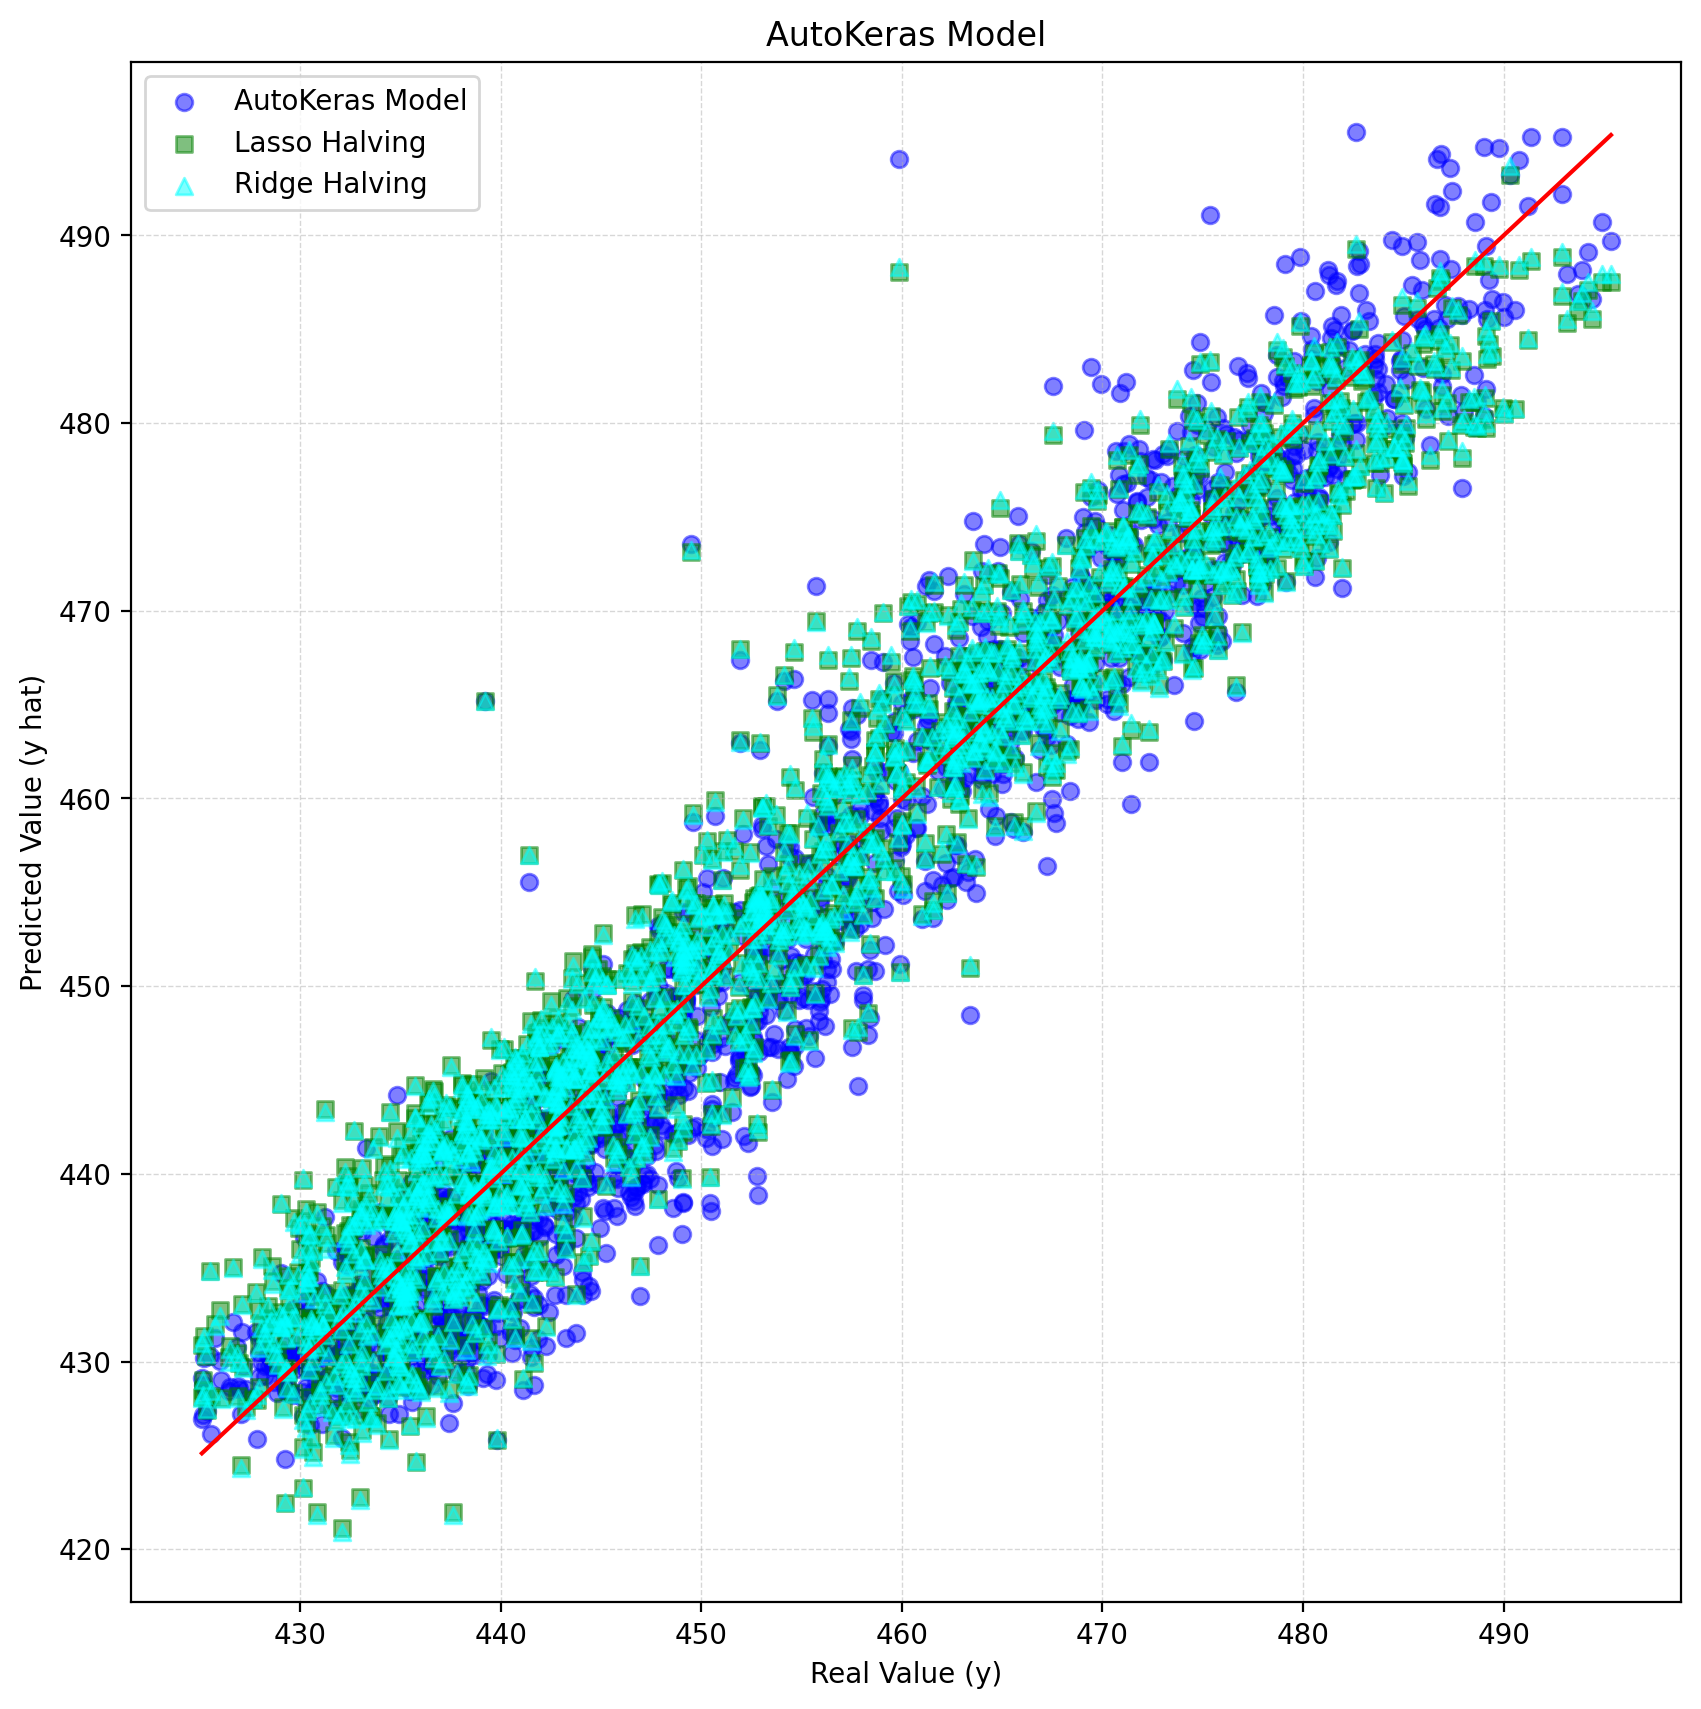

In [47]:
x = np.linspace(min(y_test), max(y_test), 500)
plt.figure(figsize = (10,10))
plt.scatter(y_test, y_pred_autokeras, color='blue', alpha=0.5, marker='o', label='AutoKeras Model')
plt.scatter(y_test, y_pred_lasso_halving, color='green', alpha=0.5, marker='s', label='Lasso Halving')
plt.scatter(y_test, y_pred_ridge_halving, color='cyan', alpha=0.5, marker='^', label='Ridge Halving')
plt.plot(x,x, color = 'red')
plt.xlabel('Real Value (y)')
plt.ylabel('Predicted Value (y hat)')
plt.title('AutoKeras Model')
plt.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend()

plt.savefig('autokeras2.png')

In [48]:
r2_score(y_test, y_pred_autokeras)

0.9258852078604711

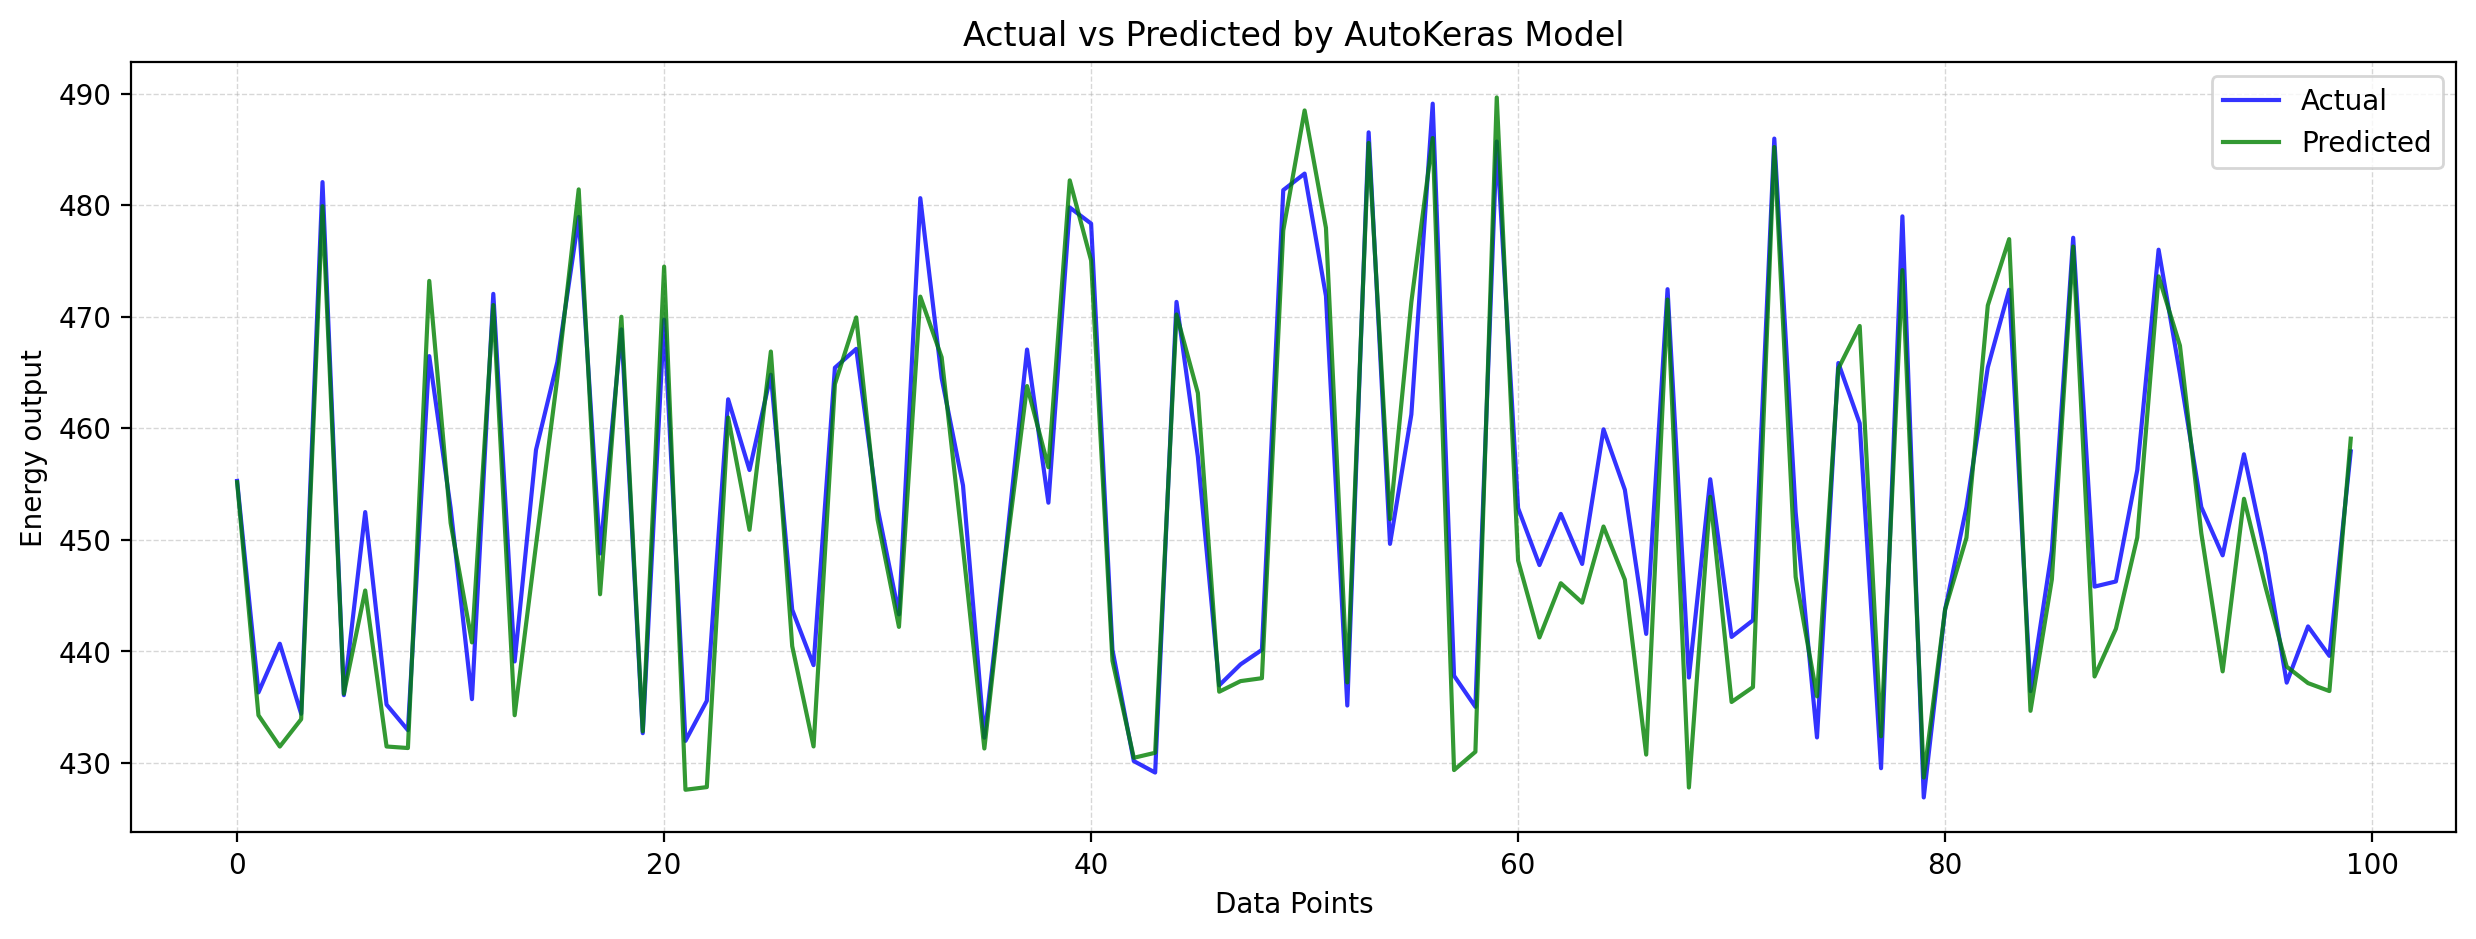

In [49]:
plt.figure(figsize = (15,5))
plt.plot(y_test[0:100], color = 'blue', label = 'Actual', alpha=0.8)
plt.plot(y_pred_autokeras[0:100], color = 'green', label = 'Predicted', alpha=0.8)
plt.xlabel('Data Points')
plt.ylabel('Energy output')
plt.title('Actual vs Predicted by AutoKeras Model')
plt.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend()

plt.savefig('autokeras_2.png')

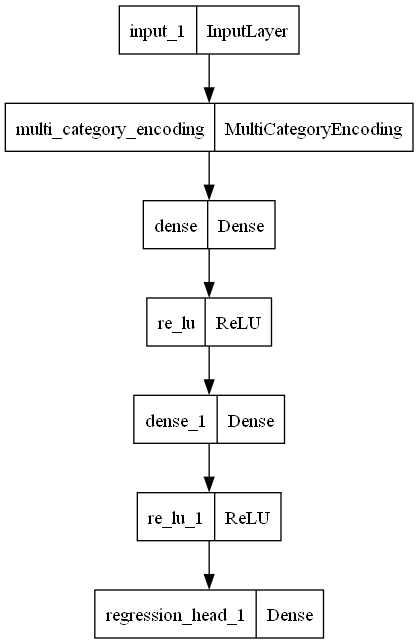

In [50]:
plot_model(model)

# **Section C: PyCaret**

In [51]:
# PyCaret
from pycaret.regression import *

In [52]:
s = setup(data, target = 'PE', normalize = True)

In [53]:
best = compare_models()

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [54]:
print(best)

ExtraTreesRegressor(n_jobs=-1, random_state=2281)


In [55]:
finalize_model(best)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['AT', 'V', 'AP', 'RH'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 ExtraTreesRegressor(n_jobs=-1, random_state=2281))])

In [56]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…